# Ensemble/Voting Classification in Python with Scikit-Learn
ref：https://www.kaggle.com/c/titanic/submit

In [662]:
import pandas as pds
import numpy as np
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

In [663]:
warnings.filterwarnings('ignore')

In [664]:
def get_nulls(training, testing):
    print("Training Data:")
    print(pds.isnull(training).sum())
    print("training data length:", len(training))    
    print("Testing Data:")
    print(pds.isnull(testing).sum())
    print("testing data length:", len(testing))        

In [665]:
training_data = pds.read_csv("data/train.csv")
testing_data = pds.read_csv("data/test.csv")
get_nulls(training_data, testing_data)

Training Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
training data length: 891
Testing Data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
testing data length: 418


In [666]:
# 重組資料集（將 trainging, testing 資料)
pool_data = pds.concat([training_data, testing_data], axis  = 0)
pool_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [667]:
# Drop the cabin column, as there are too many missing values
# Drop the ticket numbers too, as there are too many categories
# Drop names as they won't really help predict survivors

training_data.drop(labels = ["Cabin", "Name", "Ticket"], axis = 1, inplace= True)
testing_data.drop(labels = ["Cabin", "Name", "Ticket"], axis = 1, inplace= True)

# Taking the mean/average value would be impacted by the skew
# so we should use the median value to impute missing values

training_data["Age"].fillna(training_data["Age"].median(),inplace=True)
training_data["Embarked"].fillna(training_data["Embarked"].mode()[0], inplace=True)
testing_data["Age"].fillna(testing_data["Age"].median(),inplace=True)
testing_data["Embarked"].fillna(testing_data["Embarked"].mode()[0], inplace=True)
testing_data["Fare"].fillna(testing_data["Fare"].median(), inplace=True)

get_nulls(training_data, testing_data)

Training Data:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
training data length: 891
Testing Data:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
testing data length: 418


In [668]:
# Fit the encoder on the data (Feature: Sex)
encoder_1 = LabelEncoder()
encoder_1.fit(training_data["Sex"])

# Transform and replace training data
training_sex_encoded = encoder_1.transform(training_data["Sex"])
training_data["Sex_enc"] = training_sex_encoded

encoder_1.fit(testing_data["Sex"])
test_sex_encoded = encoder_1.transform(testing_data["Sex"])
testing_data["Sex_enc"] = test_sex_encoded

# Fit the encoder on the data (Feature: Embarked)
encoder_2 = LabelEncoder()

encoder_2.fit(training_data["Embarked"])
training_embarked_encoded = encoder_2.transform(training_data["Embarked"])
training_data["Embarked_enc"] = training_embarked_encoded

encoder_2.fit(testing_data["Embarked"])
test_embarked_encoded = encoder_2.transform(testing_data["Embarked"])
testing_data["Embarked_enc"] = test_embarked_encoded

#Any value we want to reshape needs be turned into array first
ages_train = np.array(training_data["Age"]).reshape(-1, 1)
ages_test = np.array(testing_data["Age"]).reshape(-1, 1)

# Scaler takes arrays
scaler = StandardScaler()
training_data["Age_Scalered"] = scaler.fit_transform(ages_train)
testing_data["Age_Scalered"] = scaler.fit_transform(ages_test)

In [669]:
training_data.drop(labels = ["Embarked", "Sex", "Age"], axis = 1, inplace = True)
testing_data.drop(labels = ["Embarked", "Sex", "Age"], axis = 1, inplace = True)
# print(training_data.columns)

In [670]:
# Now to select our training/testing data
X_features = training_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = training_data['Survived']

print(X_features.head(5))
print(y_labels.head(5))

# Make the train/test data from validation

X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.1, random_state=12)

   Pclass  SibSp  Parch     Fare  Sex_enc  Embarked_enc  Age_Scalered
0       3      1      0   7.2500        1             2     -0.565736
1       1      1      0  71.2833        0             0      0.663861
2       3      0      0   7.9250        0             2     -0.258337
3       1      1      0  53.1000        0             2      0.433312
4       3      0      0   8.0500        1             2      0.433312
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


## Simple Averaging Approach

In [671]:
print("Sample Counts for Training Data:", len(X_train))
print("Sample Counts for Validation Data:", len(X_val))

Sample Counts for Training Data: 801
Sample Counts for Validation Data: 90


In [672]:
LogReg_clf = LogisticRegression()
DeTree_clf = DecisionTreeClassifier()
SVC_clf = SVC()

LogReg_clf.fit(X_train, y_train)
DeTree_clf.fit(X_train, y_train)
SVC_clf.fit(X_train, y_train)

LogReg_pred = LogReg_clf.predict(X_val)
DeTree_pred = DeTree_clf.predict(X_val)
SVC_pred = SVC_clf.predict(X_val)
prediced_Y_traing  = pds.DataFrame(zip(LogReg_pred, DeTree_pred, SVC_pred), columns=['LogReg_pred','DeTree_pred','SVC_pred'])
prediced_Y_traing["averaged_preds"] = prediced_Y_traing.mode(axis = 1) # (LogReg_pred + DeTree_pred + SVC_pred) // 3
averaged_preds = prediced_Y_traing["averaged_preds"].array

In [673]:
AccScore = round(accuracy_score(y_val, averaged_preds), 6)
print(AccScore)

0.788889


## Bagging Classification Example

In [674]:
def bagging_ensemble(model):
    k_folds = KFold(n_splits= 20, random_state=12,shuffle=True)
    results = cross_val_score(model, X_train, y_train, cv=k_folds)
    print(results.mean())

## Boosting Classification Example

In [675]:
k_folds = KFold(n_splits=20, random_state=12, shuffle=True)
num_estimators = [x for x in range(10, 110, 10)]
for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators = i, random_state = 12)
    results = cross_val_score(ada_boost, X_train, y_train ,cv = k_folds)
    print("Results for {} estimators:".format(i))
    print(round(results.mean(), 6))

Results for 10 estimators:
0.805183
Results for 20 estimators:
0.805213
Results for 30 estimators:
0.810183
Results for 40 estimators:
0.817652
Results for 50 estimators:
0.816402
Results for 60 estimators:
0.816433
Results for 70 estimators:
0.820152
Results for 80 estimators:
0.815152
Results for 90 estimators:
0.811402
Results for 100 estimators:
0.810152


## voting\Stacking Classification Example

In [676]:
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DeTree', DeTree_clf), ('LogReg', LogReg_clf)], voting = 'hard', flatten_transform = True)
voting_clf.fit(X_train, y_train)
preds = voting_clf.predict(X_val)      
AccScore = round(accuracy_score(y_val, preds), 6)
l_loss = round(log_loss(y_val, preds), 6)
f1 = round(f1_score(y_val, preds), 6)
print("Accuracy Score for Voting Rule = hard is: ", AccScore)
print("Log Loss for Voting Rule = hard is: ",  l_loss)
print("F1 Score for Voting Rule = hard is ", f1)

# VotingRule = ['hard', 'soft']
# for myVote in VotingRule:
#     voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DeTree', DeTree_clf), ('LogReg', LogReg_clf)], voting = myVote, flatten_transform = True)
#     voting_clf.fit(X_train, y_train)
#     # if myVote == 'hard':
#     preds = voting_clf.predict(X_val)
#     # else:
#     #    preds = voting_clf.predict_proba(X_val)        
#     AccScore = round(accuracy_score(y_val, preds), 6)
#     l_loss = round(log_loss(y_val, preds), 6)
#     f1 = round(f1_score(y_val, preds), 6)
#     print("Voting Rule = " + myVote + " Accuracy Score is: ", AccScore)
#     print("Voting Rule = " + myVote + " Log Loss is: ",  l_loss)
#     print("Voting Rule = " + myVote + " F1 Score is: ", f1)

Accuracy Score for Voting Rule = hard is:  0.788889
Log Loss for Voting Rule = hard is:  7.609216
F1 Score for Voting Rule = hard is  0.688525


In [677]:
test_df = testing_data.drop(labels = ["PassengerId"], axis = 1)

In [678]:
submission_df = pds.DataFrame(columns = ["PassengerId", "Survived"])
submission_df.PassengerId = testing_data.PassengerId

In [679]:
submission_df.Survived = voting_clf.predict(test_df)
submission_df.to_csv("Submission_voting.csv", header = True, index = False)

In [680]:
submission_df.Survived = LogReg_clf.predict(test_df).astype(int)
submission_df.to_csv("Submission_LogReg.csv", header = True, index = False)

# Extra: 整批資料重新處理

In [681]:
# 針對 Age 的缺失值做更細微的分析後再補植
# 1. 分析姓名中的稱謂欄位
# 2. 有無配偶兄弟同行衍生 Y(1)/N(0) 欄位
# 3. 有無父母小孩同行衍生 Y(1)/N(0) 欄位
# 4. 將艙等、Mr/Mrs/Miss、有無配偶兄弟、有無父母小孩同行等四構面統計平均年齡，以此平均年齡補值

C_Title = []
CustName = pool_data.Name.to_list()

for C_Name in CustName:
    myPos01 = C_Name.index(',')
    myPos02 = C_Name.index('.')
    TitleCode = C_Name[myPos01 + 1: myPos02].strip()
    C_Title.append(TitleCode)

pool_data['TitleCode'] = C_Title

In [682]:
TitleStat = pool_data[pool_data['Survived'].notnull()].groupby('TitleCode')['Survived'].agg(['sum','count'])
TitleStat["Survival_ratio"] = TitleStat["sum"] / TitleStat["count"]
Overall_Survival_ratio = round(training_data['Survived'].sum() / len(training_data), 6)

# 生存組稱謂（存活率大於整體平均者）
TitleStat_S = TitleStat[TitleStat['Survival_ratio'] >= Overall_Survival_ratio].index.to_list()
S_Group = []
for TitleCode in C_Title:
    if TitleCode in TitleStat_S:
       S_Group.append(1)
    else:
       S_Group.append(0)
pool_data['Survival_Group'] = S_Group

In [683]:
pool_data['IsSibSp'] = np.where(pool_data["SibSp"] > 0, 1, 0)
pool_data['IsParch'] = np.where(pool_data["Parch"] > 0, 1, 0)
pool_data['FourAttrMerge'] = pool_data['Pclass'].astype(str) + pool_data['Survival_Group'].astype(str) + pool_data['IsSibSp'].astype(str) + pool_data['Parch'].astype(str)
AvgAgebyFourAttrMerge = pds.DataFrame(pool_data[pool_data["Survived"].notnull()].groupby(["FourAttrMerge"])["Age"].mean().round(0))

In [684]:
AvgAgebyFourAttrMergeDict = pds.Series(AvgAgebyFourAttrMerge.Age, index = AvgAgebyFourAttrMerge.index).to_dict()
overall_age_median = pool_data["Age"].median()

In [685]:
def impute_age(cols):
    Age = cols[0]
    FourAttrMerge = cols[1]
    if pds.isnull(Age):
       if FourAttrMerge in AvgAgebyFourAttrMergeDict.keys():
          return AvgAgebyFourAttrMergeDict.get(FourAttrMerge)
       else:
          return overall_age_median
    else:
        return Age

In [686]:
pool_data['Age'] = pool_data[['Age', 'FourAttrMerge']].apply(impute_age, axis=1)

In [687]:
print(pds.isnull(pool_data).sum())

PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 1
Cabin             1014
Embarked             2
TitleCode            0
Survival_Group       0
IsSibSp              0
IsParch              0
FourAttrMerge        0
dtype: int64


In [688]:
pool_data.drop(labels = ["Cabin", "Name", "Ticket", "Survival_Group", "IsSibSp", "IsParch", "FourAttrMerge", "TitleCode"], axis = 1, inplace= True)
pool_data["Embarked"].fillna(pool_data["Embarked"].mode()[0], inplace=True)
pool_data["Fare"].fillna(pool_data["Fare"].median(), inplace=True)

In [689]:
print(pds.isnull(pool_data).sum())

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64


In [690]:
# Embarked_Dummies, Sex
Embarked_Dummy = pds.get_dummies(pool_data['Embarked'], prefix='Embarked', drop_first = True, dtype = int)
Sex_Dummy = pds.get_dummies(pool_data['Sex'], prefix='Sex', drop_first = True, dtype = int)
# Embarked_Dummies
pool_data_Final = pds.concat([pool_data, Embarked_Dummy, Sex_Dummy], axis = 1)

In [691]:
# Scaler takes arrays
ages_pool = np.array(pool_data_Final["Age"]).reshape(-1, 1)
scaler = StandardScaler()
pool_data_Final["Age_Scalered"] = scaler.fit_transform(ages_pool)

In [692]:
pool_data_Final.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Embarked_Q', 'Embarked_S', 'Sex_male',
       'Age_Scalered'],
      dtype='object')

In [693]:
pool_data_Final.drop(labels = ["Embarked", "Age", "Sex"], axis = 1, inplace = True)
training_data_x2 = pool_data_Final[pool_data["Survived"].notnull()]
testing_data_x2 = pool_data_Final[pool_data["Survived"].isnull()]
testing_data_x2.drop(labels = ["Survived"], axis = 1, inplace= True)
testing_data_x2.columns

Index(['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked_Q',
       'Embarked_S', 'Sex_male', 'Age_Scalered'],
      dtype='object')

In [694]:
X_features = training_data_x2.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = training_data_x2['Survived']

print(X_features.head(5))
print(y_labels.head(5))

# Make the train/test data from validation

X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X_features, y_labels, test_size=0.1, random_state=12)

   Pclass  SibSp  Parch     Fare  Embarked_Q  Embarked_S  Sex_male  \
0       3      1      0   7.2500           0           1         1   
1       1      1      0  71.2833           0           0         0   
2       3      0      0   7.9250           0           1         0   
3       1      1      0  53.1000           0           1         0   
4       3      0      0   8.0500           0           1         1   

   Age_Scalered  
0     -0.570395  
1      0.627635  
2     -0.270888  
3      0.403004  
4      0.403004  
0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64


In [699]:
LogReg_clf_pool = LogisticRegression()
DeTree_clf_pool = DecisionTreeClassifier()
SVC_clf_pool = SVC()

LogReg_clf_pool.fit(X_train_02, y_train_02)
DeTree_clf_pool.fit(X_train_02, y_train_02)
SVC_clf_pool.fit(X_train_02, y_train_02)

LogReg_pred = LogReg_clf_pool.predict(X_val_02)
DeTree_pred = DeTree_clf_pool.predict(X_val_02)
SVC_pred = SVC_clf_pool.predict(X_val_02)
prediced_Y_traing = pds.DataFrame(zip(LogReg_pred, DeTree_pred, SVC_pred), columns=['LogReg_pred','DeTree_pred','SVC_pred'])
prediced_Y_traing["averaged_preds"] = prediced_Y_traing.mode(axis = 1) # (LogReg_pred + DeTree_pred + SVC_pred) // 3
averaged_preds = prediced_Y_traing["averaged_preds"].array

In [703]:
AccScore = round(accuracy_score(y_val_02, averaged_preds), 6)
print(AccScore)

0.777778


In [705]:
test_df = testing_data_x2.drop(labels = ["PassengerId"], axis = 1)
submission_df = pds.DataFrame(columns = ["PassengerId", "Survived"])
submission_df.PassengerId = testing_data_x2.PassengerId

In [706]:
submission_df.Survived = LogReg_clf_pool.predict(test_df).astype(int)
submission_df.to_csv("Submission_LogReg_pool.csv", header = True, index = False)

In [707]:
submission_df.Survived = DeTree_clf_pool.predict(test_df).astype(int)
submission_df.to_csv("Submission_DTree_pool.csv", header = True, index = False)

In [708]:
for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators = i, random_state = 12)
    results = cross_val_score(ada_boost, X_train_02, y_train_02, cv = k_folds)
    print("Pool Results for {} estimators:".format(i))
    print(round(results.mean(), 6))

Pool Results for 10 estimators:
0.810183
Pool Results for 20 estimators:
0.810152
Pool Results for 30 estimators:
0.820183
Pool Results for 40 estimators:
0.820152
Pool Results for 50 estimators:
0.822652
Pool Results for 60 estimators:
0.823902
Pool Results for 70 estimators:
0.817652
Pool Results for 80 estimators:
0.816402
Pool Results for 90 estimators:
0.823902
Pool Results for 100 estimators:
0.821402


In [709]:
myAdaBoost = AdaBoostClassifier(n_estimators = 60, random_state = 12)
myAdaBoost.fit(X_train_02, y_train_02)

AdaBoostClassifier(n_estimators=60, random_state=12)

In [710]:
submission_df.Survived = myAdaBoost.predict(test_df).astype(int)
submission_df.to_csv("Submission_AdaBoost_pool.csv", header = True, index = False)

In [714]:
voting_clf_pool = VotingClassifier(estimators=[('AdaBoost', myAdaBoost), ('DeTree', DeTree_clf_pool), ('LogReg', LogReg_clf_pool)], voting = 'hard', flatten_transform = True)
voting_clf_pool.fit(X_train_02, y_train_02)
preds = voting_clf_pool.predict(X_val_02)      
AccScore = round(accuracy_score(y_val_02, preds), 6)
l_loss = round(log_loss(y_val_02, preds), 6)
f1 = round(f1_score(y_val_02, preds), 6)
print("Accuracy Score for Voting Rule = hard is: ", AccScore)
print("Log Loss for Voting Rule = hard is: ",  l_loss)
print("F1 Score for Voting Rule = hard is ", f1)

Accuracy Score for Voting Rule = hard is:  0.811111
Log Loss for Voting Rule = hard is:  6.808246
F1 Score for Voting Rule = hard is  0.753623


In [715]:
submission_df.Survived = voting_clf_pool.predict(test_df).astype(int)
submission_df.to_csv("Submission_Voting_pool.csv", header = True, index = False)

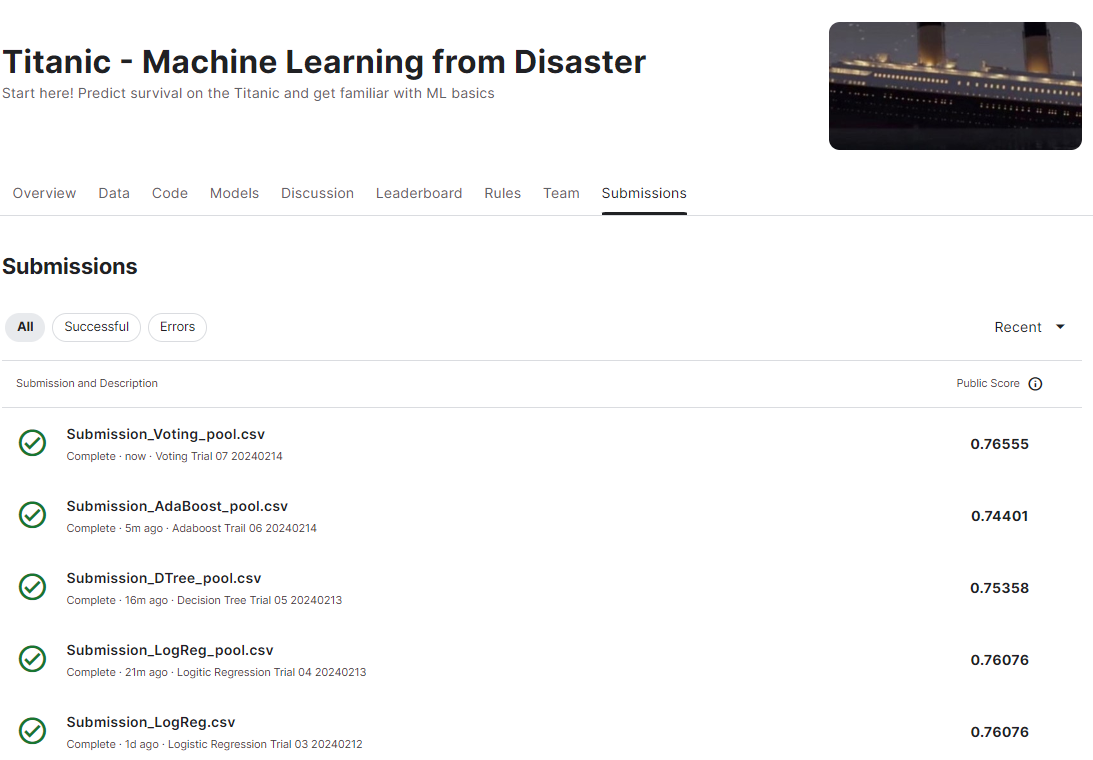